# Rock paper scissors game


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

In order to carry out numerical experiments to compare the convergence of the algorithm with RM, RM+ and exponential weights, I chose to implement the finite two-player zero-sum "rock, paper, scissors" game. This game is well known, quick to understand and easy to implement, making it a perfect candidate.


In [2]:
A = np.array([[0, -1, 1], [1, 0, -1], [-1, 1, 0]]) # [rock, paper, scissors]*[rock, paper, scissors]
delta_m = np.array([[1,0,0], [0,1,0], [0,0,1]]) # simplex for 3 actions in rock, paper, scissors for player 1
delta_n = np.array([[1,0,0], [0,1,0], [0,0,1]]) # simplex for 3 actions in rock, paper, scissors for player 2

Definition of the duality gap $\delta_A : \Delta_m \times \Delta_n \rightarrow \mathbb{R}_+$ function to proof the convergence of the algorithms.


In [3]:
def DualityGap(a, b, A=A, delta_m=delta_m, delta_n=delta_m):
    maxi = np.max([np.dot(a_, A@b) for a_ in delta_m])
    mini = np.min([np.dot(a, A@b_) for b_ in delta_n])
    return maxi - mini  

## Non Optimistic Algorithms


### Exponential Weights


$$
\begin{align*}
    &y_t = \eta_t \sum^{t-1}_{s=0} Ab_s \qquad & z_t=-\eta'_t \sum^{t-1}_{s=0} A^\intercal a_s \\
    & \text{where} \\
    &\eta_t = \frac{\sqrt{2 \log m}}{\|A\|_{\infty} \sqrt{t+1}} & \eta'_t = \frac{\sqrt{2 \log n}}{\|A\|_{\infty} \sqrt{t+1}} \\
    & \text{and} \\
    &a_t=\left( \frac{\exp (y_{t,i})}{\sum^m_{i'=1} \exp (y_{t,i'})}  \right)_{1 \leq i \leq m} & b_t=\left( \frac{\exp (z_{t,j})}{\sum^m_{j'=1} \exp (z_{t,j'})}  \right)_{1 \leq j \leq m}

\end{align*}
$$


In [4]:
class ExponentialWeights:
    def __init__(self, A, a0, b0):
        self.player1 = self.Player1(A, self.eta, a0)
        self.player2 = self.Player2(A, self.eta, b0)
        self.A = A

    def eta(self, t, num_actions):
            return np.sqrt(2*np.log(num_actions))/(np.max(self.A)*np.sqrt(t+1))
    
    class Player1:
        def __init__(self, A, eta, a0):
            self.A = A
            self.m = A.shape[0]
            self.eta = eta
            self.a0 = a0
        
        def choose_action(self, t, a_, b):
            y = self.eta(t, self.m)*np.sum([self.A@b[s] for s in range(t)], axis=0)    
            a = np.exp(y)/np.sum(np.exp(y))
            return a if np.any(a) else self.a0
        
    class Player2:
        def __init__(self, A, eta, b0):
            self.A = A
            self.n = A.shape[1]
            self.eta = eta
            self.b0 = b0
        
        def choose_action(self, t, a, b_):
            z = -self.eta(t, self.n)*np.sum([self.A.T@a[s] for s in range(t)], axis=0)
            b = np.exp(z)/np.sum(np.exp(z))
            return b if np.any(b) else self.b0  

### Regret Matching (RM)


$$
a_t=
\begin{cases}
    \frac{x_{t,+}}{ \|x_{t,+}\|_1} \quad & \text{if } x_{t,+}:= \left(\sum_{s=0}^{t-1}(Ab_s-\langle a_s, Ab_s \rangle 1) \right)_+ \neq 0 \\
    a_0 \in \Delta_m \quad & \text{otherwise}
\end{cases}
$$

$$
b_t=
\begin{cases}
    \frac{w_{t,+}}{ \|w_{t,+}\|_1} \quad & \text{if } w_{t,+}:= \left(\sum_{s=0}^{t-1}(\langle a_s, Ab_s \rangle 1) - A^\intercal a_s\right)_+ \neq 0 \\
    b_0 \in \Delta_n \quad  & \text{otherwise}
\end{cases}
$$


In [5]:
class RM:
    def __init__(self, A, a0, b0):
        self.player1 = self.Player1(A, a0)
        self.player2 = self.Player2(A, b0)
        self.A = A

    
    class Player1:
        def __init__(self, A, a0):
            self.A = A
            self.a0 = a0
        
        def choose_action(self, t, a, b):
            x = np.sum([self.A@b[s] - np.dot(a[s], self.A@b[s]) for s in range(t)], axis=0)
            x[x<0] = 0
            a = x/np.sum(x)
            return a if np.any(a) else self.a0
        
    class Player2:
        def __init__(self, A, b0):
            self.A = A
            self.b0 = b0
        
        def choose_action(self, t, a, b):
            w = np.sum([np.dot(a[s], self.A@b[s]) - self.A.T@a[s] for s in range(t)], axis=0)
            w[w<0] = 0
            b = w/np.sum(w)
            return b if np.any(b) else self.b0

### Regret Matching+ (RM+)


$$
\begin{align*}
    a_t &=
    \begin{cases}
        \frac{x_{t,+}}{ \|x_{t,+}\|_1} \quad & \text{if } x_{t,+} \neq 0 \\
        a_0 \in \Delta_m \quad & \text{otherwise}
    \end{cases}
    \qquad \qquad
    &b_t &=
    \begin{cases}
        \frac{w_{t,+}}{ \|w_{t,+}\|_1} \quad & \text{if } w_{t,+} \neq 0 \\
        b_0 \in \Delta_n \quad  & \text{otherwise}
    \end{cases} \\
    x_{t+1} &= (x_t + Ab_t - \langle a_t, Ab_t \rangle 1)_+
    &w_{t+1} &= (w_t + \langle a_t, Ab_t \rangle 1 - A^\intercal a_t)_+
\end{align*}
$$


In [6]:
class RMplus:
    def __init__(self, A, a0, b0):
        self.player1 = self.Player1(A, a0)
        self.player2 = self.Player2(A, b0)
        self.A = A

    
    class Player1:
        def __init__(self, A, a0):
            self.A = A
            self.a0 = a0
            self.x = 0 # initialize x arbitrarily to 0
        
        def choose_action(self, t, a, b):
            x = self.x + A@b[t-1] - np.dot(a[t-1], A@b[t-1]) # t-1 because we define w[t+1] as w[t]
            x[x<0] = 0
            self.x = x
            a = x/np.sum(x)
            return a if np.any(a) else self.a0
        
    class Player2:
        def __init__(self, A, b0):
            self.A = A
            self.b0 = b0
            self.w = 0 # initialize w arbitrarily to 0
        
        def choose_action(self, t, a, b):
            w = self.w + np.dot(a[t-1], A@b[t-1]) - self.A.T@a[t-1] # t-1 because we define w[t+1] as w[t]
            w[w<0] = 0
            self.w = w
            b = w/np.sum(w)
            return b if np.any(b) else self.b0

### Adaptation of AdaGrad-Norm


$$
\begin{align*}
    a_t &=
    \begin{cases}
        \frac{x_{t,+}}{ \|x_{t,+}\|_1} \quad & \text{if } x_{t,+} \neq 0 \\
        a_0 \in \Delta_m \quad & \text{otherwise}
    \end{cases}
    \qquad \qquad
    &b_t &=
    \begin{cases}
        \frac{w_{t,+}}{ \|w_{t,+}\|_1} \quad & \text{if } w_{t,+} \neq 0 \\
        b_0 \in \Delta_n \quad  & \text{otherwise}
    \end{cases} \\
    x_{t+1} &= (x_t + \gamma _t (Ab_t - \langle a_t, Ab_t \rangle 1))_+
    &w_{t+1} &= (w_t + \gamma' _t(\langle a_t, Ab_t \rangle 1 - A^\intercal a_t))_+ \\
    \text{with} \\
    \gamma _t &:= \frac{\gamma}{\sqrt{\sum^t_{s=0} \| Ab_s - \langle a_s, Ab_s \rangle 1 \|^2_2 }}
    &\gamma' _t &:= \frac{\gamma}{\sqrt{\sum^t_{s=0} \| \langle a_s, Ab_s \rangle 1 - A^\intercal a_s \|^2_2 }}
\end{align*}
$$


In [7]:
class AdaGradNorm:
    def __init__(self, A, a0, b0):
        self.player1 = self.Player1(A, self.gamma, a0)
        self.player2 = self.Player2(A, self.gamma, b0)
        self.A = A

    def gamma(self, norms, gam=1): # no care of gam because the algo is parameter free
            return gam/np.sqrt(np.sum(norms**2))

    
    class Player1:
        def __init__(self, A, gamma, a0):
            self.A = A
            self.gamma = gamma
            self.a0 = a0
            self.x = 0 # initialize x arbitrarily to 0
        
        def choose_action(self, t, a, b):
            norms = np.array([np.linalg.norm(A@b[s] - np.dot(a[s], A@b[s])) for s in range(t)])
            x = self.x + self.gamma(norms)*(A@b[t-1] - np.dot(a[t-1], A@b[t-1])) # t-1 because we define w[t+1] as w[t]
            x[x<0] = 0
            self.x = x
            a = x/np.sum(x)
            return a if np.any(a) else self.a0
        
    class Player2:
        def __init__(self, A, gamma, b0):
            self.A = A
            self.gamma = gamma
            self.b0 = b0
            self.w = 0 # initialize w arbitrarily to 0
        
        def choose_action(self, t, a, b):
            norms = np.array([np.linalg.norm(np.dot(a[s], A@b[s]) - self.A.T@a[s]) for s in range(t)])
            w = self.w + self.gamma(norms)*(np.dot(a[t-1], A@b[t-1]) - self.A.T@a[t-1]) # t-1 because we define w[t+1] as w[t]
            w[w<0] = 0
            self.w = w
            b = w/np.sum(w)
            return b if np.any(b) else self.b0

_**Note**: You can try changing the "gam" parameter in the gamma function of the AdaGrad class and see that it does not change anything. This is normal, as the algorithm is parameter-free._


## Optimistic Algorithms


### Optimistic Exponential Weights (with constant step-size)


$$
\begin{align*}
    &y_t = \eta \left( \sum^{t-1}_{s=0} Ab_s + Ab_{t-1} \right)  \qquad & z_t=-\eta \left( \sum^{t-1}_{s=0} A^\intercal a_s + A^\intercal a_{t-1} \right) \\
    & \text{and} \\
    &a_t=\left( \frac{\exp (y_{t,i})}{\sum^m_{i'=1} \exp (y_{t,i'})}  \right)_{1 \leq i \leq m} & b_t=\left( \frac{\exp (z_{t,j})}{\sum^m_{j'=1} \exp (z_{t,j'})}  \right)_{1 \leq j \leq m}

\end{align*}
$$


In [8]:
class OptimisticExponentialWeights:
    def __init__(self, A, a0, b0, eta=0.1):
        self.player1 = self.Player1(A, eta, a0)
        self.player2 = self.Player2(A, eta, b0)
    
    class Player1:
        def __init__(self, A, eta, a0):
            self.A = A
            self.a0 = a0
            self.eta = eta
        
        def choose_action(self, t, a_, b):
            y = self.eta*(np.sum([self.A@b[s] for s in range(t)], axis=0)+self.A@b[t-1])
            a = np.exp(y)/np.sum(np.exp(y))
            return a if np.any(a) else self.a0
        
    class Player2:
        def __init__(self, A, eta, b0):
            self.A = A
            self.eta = eta
            self.b0 = b0
        
        def choose_action(self, t, a, b_):
            z = -self.eta*(np.sum([self.A.T@a[s] for s in range(t)], axis=0)+self.A@a[t-1])
            b = np.exp(z)/np.sum(np.exp(z))
            return b if np.any(b) else self.b0  

### Optimistic Regret Matching


$$
a_t=
\begin{cases}
    \frac{x_{t,+}}{ \|x_{t,+}\|_1} \quad & \text{if } x_{t,+}:= \left(\sum_{s=0}^{t-1}(Ab_s-\langle a_s, Ab_s \rangle 1) + Ab_{t-1}-\langle a_{t-1}, Ab_{t-1} \rangle 1) \right)_+ \neq 0 \\
    a_0 \in \Delta_m \quad & \text{otherwise}
\end{cases}
$$

$$
b_t=
\begin{cases}
    \frac{w_{t,+}}{ \|w_{t,+}\|_1} \quad & \text{if } w_{t,+}:= \left(\sum_{s=0}^{t-1}(\langle a_s, Ab_s \rangle 1) - A^\intercal a_s + \langle a_{t-1}, Ab_{t-1} \rangle 1) - A^\intercal a_{t-1} \right)_+ \neq 0 \\
    b_0 \in \Delta_n \quad  & \text{otherwise}
\end{cases}
$$


In [9]:
class OptimisticRM:
    def __init__(self, A, a0, b0):
        self.player1 = self.Player1(A, a0)
        self.player2 = self.Player2(A, b0)
        self.A = A

    
    class Player1:
        def __init__(self, A, a0):
            self.A = A
            self.a0 = a0
        
        def choose_action(self, t, a, b):
            x = np.sum([self.A@b[s] - np.dot(a[s], self.A@b[s]) for s in range(t)], axis=0) + (self.A@b[t-1] - np.dot(a[t-1], self.A@b[t-1]))
            x[x<0] = 1e-10 # to avoid division by 0
            a = x/np.sum(x)
            return a if np.any(a) else self.a0
        
    class Player2:
        def __init__(self, A, b0):
            self.A = A
            self.b0 = b0
        
        def choose_action(self, t, a, b):
            w = np.sum([np.dot(a[s], self.A@b[s]) - self.A.T@a[s] for s in range(t)], axis=0) + (np.dot(a[t-1], self.A@b[t-1]) - self.A.T@a[t-1])
            w[w<0] = 1e-10 # to avoid division by 0
            b = w/np.sum(w)
            return b if np.any(b) else self.b0

### Optimistic Regret Matching+


$$
\begin{align*}
    a_t &=
    \begin{cases}
        \frac{x_{t,+}}{ \|x_{t,+}\|_1} \quad & \text{if } x_{t,+} \neq 0 \\
        a_0 \in \Delta_m \quad & \text{otherwise}
    \end{cases}
    \qquad \qquad
    &b_t &=
    \begin{cases}
        \frac{w_{t,+}}{ \|w_{t,+}\|_1} \quad & \text{if } w_{t,+} \neq 0 \\
        b_0 \in \Delta_n \quad  & \text{otherwise}
    \end{cases} \\
    x_{t+1} &= (x_t + 2(Ab_t - \langle a_t, Ab_t \rangle 1))_+
    &w_{t+1} &= (w_t + 2(\langle a_t, Ab_t \rangle 1 - A^\intercal a_t))_+
\end{align*}
$$


_**Note**: In fact this Optimistic RM+ correponds to the greedy Blackwell's algorithms with $\gamma =2$, which is parameter-free. So this new algorithm is excatly like the non optimistic RM+... In order to verify, I still write the code_.


In [10]:
class OptimisticRMplus:
    def __init__(self, A, a0, b0):
        self.player1 = self.Player1(A, a0)
        self.player2 = self.Player2(A, b0)
        self.A = A

    
    class Player1:
        def __init__(self, A, a0):
            self.A = A
            self.a0 = a0
            self.x = 0 # initialize x arbitrarily to 0
        
        def choose_action(self, t, a, b):
            x = self.x + 2*(A@b[t-1] - np.dot(a[t-1], A@b[t-1])) # 2 because it is the optimistic version
            x[x<0] = 0
            self.x = x
            a = x/np.sum(x)
            return a if np.any(a) else self.a0
        
    class Player2:
        def __init__(self, A, b0):
            self.A = A
            self.b0 = b0
            self.w = 0 # initialize w arbitrarily to 0
        
        def choose_action(self, t, a, b):
            w = self.w + 2*(np.dot(a[t-1], A@b[t-1]) - self.A.T@a[t-1]) # 2 because it is the optimistic version
            w[w<0] = 0
            self.w = w
            b = w/np.sum(w)
            return b if np.any(b) else self.b0

### Optimistic Adaptation of Adagrad-Norm


$$
\begin{align*}
    a_t &=
    \begin{cases}
        \frac{x_{t,+}}{ \|x_{t,+}\|_1} \quad & \text{if } x_{t,+} \neq 0 \\
        a_0 \in \Delta_m \quad & \text{otherwise}
    \end{cases}
    \qquad \qquad
    &b_t &=
    \begin{cases}
        \frac{w_{t,+}}{ \|w_{t,+}\|_1} \quad & \text{if } w_{t,+} \neq 0 \\
        b_0 \in \Delta_n \quad  & \text{otherwise}
    \end{cases} \\
    x_{t+1} &= (x_t + 2\gamma _t (Ab_t - \langle a_t, Ab_t \rangle 1))_+
    &w_{t+1} &= (w_t + 2\gamma' _t(\langle a_t, Ab_t \rangle 1 - A^\intercal a_t))_+ \\
    \text{with} \\
    \gamma _t &:= \frac{\gamma}{\sqrt{\sum^t_{s=0} \| Ab_s - \langle a_s, Ab_s \rangle 1 \|^2_2 + \| Ab_t - \langle a_t, Ab_t \rangle 1 \|^2_2 }}
    &\gamma' _t &:= \frac{\gamma}{\sqrt{\sum^t_{s=0} \| \langle a_s, Ab_s \rangle 1 - A^\intercal a_s \|^2_2 + \| \langle a_t, Ab_t \rangle 1 - A^\intercal a_t \|^2_2 }}
\end{align*}
$$


_**Note** : Again the multiplication by 2 is useless because we show that this adaptation is parameter-free._


In [11]:
class OptimisticAdaGradNorm:
    def __init__(self, A, a0, b0):
        self.player1 = self.Player1(A, self.gamma, a0)
        self.player2 = self.Player2(A, self.gamma, b0)
        self.A = A

    def gamma(self, norms, gam=1): # no care of gam because the algo is parameter free
            return gam/np.sqrt(np.sum(norms**2))

    
    class Player1:
        def __init__(self, A, gamma, a0):
            self.A = A
            self.gamma = gamma
            self.a0 = a0
            self.x = 0 # initialize x arbitrarily to 0
        
        def choose_action(self, t, a, b):
            norms = np.array([np.linalg.norm(A@b[s] - np.dot(a[s], A@b[s])) for s in range(t)])
            norms = np.append(norms, np.linalg.norm(A@b[t-1] - np.dot(a[t-1], A@b[t-1]))) # optimistic version
            x = self.x + self.gamma(norms)*2*(A@b[t-1] - np.dot(a[t-1], A@b[t-1])) # t-1 because we define w[t+1] as w[t]
            x[x<0] = 0
            self.x = x
            a = x/np.sum(x)
            return a if np.any(a) else self.a0
        
    class Player2:
        def __init__(self, A, gamma, b0):
            self.A = A
            self.gamma = gamma
            self.b0 = b0
            self.w = 0 # initialize w arbitrarily to 0
        
        def choose_action(self, t, a, b):
            norms = np.array([np.linalg.norm(np.dot(a[s], A@b[s]) - self.A.T@a[s]) for s in range(t)])
            norms = np.append(norms, np.linalg.norm(np.dot(a[t-1], A@b[t-1]) - self.A.T@a[t-1])) # optimistic version
            w = self.w + self.gamma(norms)*2*(np.dot(a[t-1], A@b[t-1]) - self.A.T@a[t-1]) # t-1 because we define w[t+1] as w[t]
            w[w<0] = 0
            self.w = w
            b = w/np.sum(w)
            return b if np.any(b) else self.b0

## Comparison of these algorithms


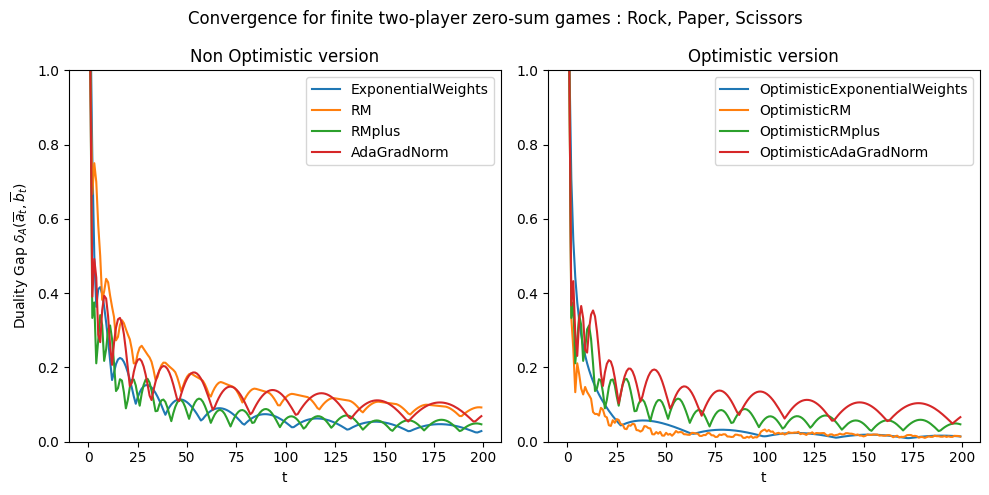

In [12]:
T = 200

a0 = np.array([0, 0, 1])
b0 = np.array([0, 0, 1])

optimizers = [ExponentialWeights, RM, RMplus, AdaGradNorm]

fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
for _ in range(2):
    for optimizer in optimizers:
        players = optimizer(A, a0, b0)
        player1 = players.player1
        player2 = players.player2

        a = np.array([a0])
        b = np.array([b0])
        duality_gap = [DualityGap(a0, b0)]

        for t in range(1,T):
            a = np.append(a, [player1.choose_action(t, a, b)], axis=0)
            b = np.append(b, [player2.choose_action(t, a, b)], axis=0)
            duality_gap.append(DualityGap(np.sum(a, axis=0)/(t+1), np.sum(b, axis=0)/(t+1)))

        axs[_].plot(duality_gap, label=optimizer.__name__)
    axs[_].set_xlabel('t')
    if _ == 0:
        axs[_].set_ylabel(r'Duality Gap $\delta_A(\overline{a}_t,\overline{b}_t)$')
    axs[_].set_ylim(0,1) # to avoid the first iterations where the duality gap is very high
    axs[_].legend()

    optimizers = [OptimisticExponentialWeights, OptimisticRM, OptimisticRMplus, OptimisticAdaGradNorm]
axs[0].set_title('Non Optimistic version')
axs[1].set_title('Optimistic version')
fig.suptitle('Convergence for finite two-player zero-sum games : Rock, Paper, Scissors')
plt.tight_layout()
plt.show()

Firstly, the `OptimisticExponentialWeights` and `OptimisticRM` algorithms exhibits uniform convergence superior to that of all other algorithms. Furthermore, `AdaGradNorm` seems to be not as good as `RMplus` despite the great similarity between them, but this could have been sensed with the larger regret bounds that we found. Thus, it should be noted that the `RM`, `AdaGradNorm` and `OptimisticAdaGradNorm` algorithms show inferior performances, while `OptimisticRM` stands out as one of the best algorithms.


Secondly, we can see that `RMplus` and `OptimisticRMplus` are identical, which is normal as seen above. However, it also seems that `AdaGradNorm` and `OptimisticAdagradNorm` are very close, which means that adding the norm of the last observed vector to the denominator root of the step sizes does not have a big impact on convergence.


Finally, while `OptimisticExponentialWeights` has the better final duality gap with `OptimisticRM`, there is an equal convergence speed between `ExponentialWeights` and `OptimisticExponentialWeights` which is surprising because the former has a nonincreasing step-size while the latter is constant.
